In [371]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt
import plotly.graph_objects as go


In [372]:
gini = pd.read_csv('./data/gini.csv')

print(gini.shape)

gini18 = gini[["Country Name", "Country Code", "2017", "2018", "2019"]]
print(gini18.shape)

# filter out rows with missing all 2017, 2018 and 2019 values
gini18 = gini18.dropna(subset=["2017", "2018", "2019"], how='all')
print(gini18.shape)

# if 2018 is missing, use 2017 and 2019 to fill it
# gini18["2018"] = gini18["2018"].fillna((gini18["2017"] + gini18["2019"]) / 2)
# if gini18["2018"].isna():
#     gini18["2018"] = gini18["2017"] if gini18["2018"].isna() else gini18["2018"]
    
# if 2018 is missing, use 2017 value to fill it, if 2017 is also missing, use 2019 value
gini18["2018"] = gini18["2018"].fillna(gini18["2017"])
gini18["2018"] = gini18["2018"].fillna(gini18["2019"])


print(gini18.shape)

(266, 68)
(266, 5)
(114, 5)
(114, 5)


In [373]:

incomet = pd.read_csv('./data/income_top_10.csv')
incomet = incomet[["Country Name", "Country Code", "2017", "2018", "2019"]]

print(incomet.shape)
incomet = incomet.dropna(subset=["2017", "2018", "2019"], how='all')

# incomet["2018"] = incomet["2018"].fillna((incomet["2017"] + incomet["2019"]) / 2)
incomet["2018"] = incomet["2018"].fillna(incomet["2017"])
incomet["2018"] = incomet["2018"].fillna(incomet["2019"])

print(incomet.shape)

(266, 5)
(114, 5)


In [374]:
incomeb = pd.read_csv('./data/income_bot_10.csv')
incomeb = incomeb[["Country Name", "Country Code", "2017", "2018", "2019"]]
print(incomeb.shape)
incomeb = incomeb.dropna(subset=["2017", "2018", "2019"], how='all')
incomeb["2018"] = incomeb["2018"].fillna(incomeb["2017"])
incomeb["2018"] = incomeb["2018"].fillna(incomeb["2019"])
print(incomeb.shape)

(266, 5)
(114, 5)


In [375]:
# Reading the regressor dataframes
gdp = pd.read_csv('./data/gdp_per_capita.csv')
lit = pd.read_csv('./data/literacy_rate.csv')
lif = pd.read_csv('./data/life_expectancy.csv')
urb = pd.read_csv('./data/urban_population_percentage.csv')
pop = pd.read_csv('./data/population_density.csv')

In [376]:
def clean_up(target, frames):
    """
    target: the dataframe to be used for cleaning
    frames: the list of dataframes to be cleaned
    
    Returns X, y where X is the feature matrix combining all the dataframes in frames and y is the target dataframe
    """
    countries = target["Country Code"]
    print(countries.shape)
    X = pd.DataFrame()
    for name, frame in frames.items():
        # for each frame, filter out the rows that are not in the countries list
        # print(frame.columns)
        frame = frame[["Country Code", "2017", "2018", "2019"]]
        frame = frame[frame["Country Code"].isin(countries)]
        # now, check if atleast one of 2017, 2018, 2019 is missing
        frame = frame.dropna(subset=["2017", "2018", "2019"], how='all')
        # if 2018 is missing, use 2017 and 2019 to fill it
        # frame[name] = frame["2018"].fillna((frame["2017"] + frame["2019"]) / 2)
        frame[name] = frame["2018"].fillna(frame["2017"])
        frame[name] = frame["2018"].fillna(frame["2019"])
        
        # drop 2018, 2019, 2017 columns from frame
        frame = frame.drop(columns=["2017", "2018", "2019"])
        # print(frame.shape)
        # concat the frame with X
        # if len(X) == 0:
        #     X = frame
        # else:
        #     X = pd.merge(X, frame, on="Country Code", how="outer")
        X = pd.concat([X, frame], axis=1)
    
    # filter out all rows from X that has any missing value
    
    X = pd.concat([X, target["2018"]], axis=1)
    
    X = X.dropna()
    # only keep one Country Code col and drop the other two in X
    X = X.drop(columns=["Country Code"])
    
    
    # extract last column from X and drop that col from X as well
    y = X["2018"]
    X = X.drop(columns=["2018"])
    # y = target["2018"]
    return X, y


## Gini index

In [377]:
frames = {
    "gdp": gdp,
    # "lit": lit,
    "lif": lif,
    "urb": urb,
    "pop": pop
}
X, y = clean_up(gini18, frames)
print(X.shape, y.shape)

est2 = sm.add_constant(X)
est = sm.OLS(y, est2).fit()
print(est.summary())

(114,)
(113, 4) (113,)
                            OLS Regression Results                            
Dep. Variable:                   2018   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     5.943
Date:                Wed, 06 Nov 2024   Prob (F-statistic):           0.000232
Time:                        16:56:04   Log-Likelihood:                -360.82
No. Observations:                 113   AIC:                             731.6
Df Residuals:                     108   BIC:                             745.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         46.9647      7.

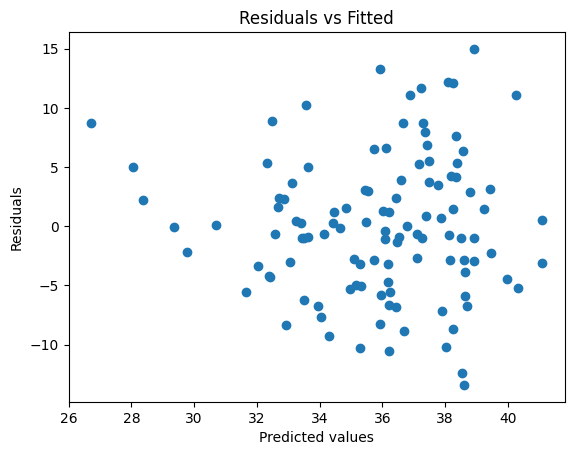

In [378]:
# Heteroskedasticity test

# Plot the residual error terms against the y_pred
y_pred = est.predict(est2)

residuals = y - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

In [379]:
# use the goldfeld-quandt test to check for heteroskedasticity
from statsmodels.stats.diagnostic import het_goldfeldquandt
name = ['F statistic', 'p-value']

test = het_goldfeldquandt(y, est2)
print(dict(zip(name, test)))


{'F statistic': np.float64(0.7606007977193291), 'p-value': np.float64(0.8350330997409645)}


In [380]:
# use the generalised white test to check for heteroskedasticity
from statsmodels.stats.diagnostic import het_white
# name = ['F statistic', 'p-value']
name = ["Lm value", "Lm p-value", "F value", "p-value"]

test = het_white(est.resid, est2)
print(dict(zip(name, test)))


{'Lm value': np.float64(12.664142166962394), 'Lm p-value': np.float64(0.5531230623858561), 'F value': np.float64(0.8835225719229092), 'p-value': np.float64(0.5785608525491697)}


In [381]:
# Variance Inflation Factor

# Calculate the VIF for each estimated coefficient using statsmodels package
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,VIF Factor
0,2.258271
1,16.691167
2,18.642489
3,1.481158


In [382]:
frames = {
    "gdp": gdp,
    # "lit": lit,
    "lif": lif,
    # "urb": urb,
    "pop": pop
}
X, y = clean_up(gini18, frames)
print(X.shape, y.shape)

est2 = sm.add_constant(X)
est = sm.OLS(y, est2).fit()
print(est.summary())

(114,)
(113, 3) (113,)
                            OLS Regression Results                            
Dep. Variable:                   2018   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     5.880
Date:                Wed, 06 Nov 2024   Prob (F-statistic):           0.000928
Time:                        16:56:04   Log-Likelihood:                -363.58
No. Observations:                 113   AIC:                             735.2
Df Residuals:                     109   BIC:                             746.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         43.4005      7.

In [383]:
# Transform gdp to log gdp
# X["gdp"] = np.log(X["gdp"]) 

X["log_gdp"] = np.log(X["gdp"])
X["gdp_2"] = X["gdp"] ** 2

# gdp + gdp_2 = 0.218
# gdp = 0.18
# gdp + log gdp = 0.195
# gdp + log gdp + gdp_2 = 0.219
# gdp + gdp_2 + gdp_3 = 0.071

print(X.columns)
est2 = sm.add_constant(X)
est = sm.OLS(y, est2).fit()
print(est.summary())
    

Index(['gdp', 'lif', 'pop', 'log_gdp', 'gdp_2'], dtype='object')
                            OLS Regression Results                            
Dep. Variable:                   2018   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     4.268
Date:                Wed, 06 Nov 2024   Prob (F-statistic):            0.00141
Time:                        16:56:04   Log-Likelihood:                -361.78
No. Observations:                 113   AIC:                             735.6
Df Residuals:                     107   BIC:                             751.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

Addition of new variables makes the model explain better (increments of R2 consistent with increase in number of variables).

## Income top 10% 

In [384]:
frames = {
    "gdp": gdp,
    # "lit": lit,
    "lif": lif,
    "urb": urb, 
    "pop": pop
}
X, y = clean_up(incomet, frames)
print(X.shape, y.shape)

est2 = sm.add_constant(X)
est = sm.OLS(y, est2).fit()
print(est.summary())

(114,)
(113, 4) (113,)
                            OLS Regression Results                            
Dep. Variable:                   2018   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     6.333
Date:                Wed, 06 Nov 2024   Prob (F-statistic):           0.000129
Time:                        16:56:04   Log-Likelihood:                -327.16
No. Observations:                 113   AIC:                             664.3
Df Residuals:                     108   BIC:                             678.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         38.3353      5.

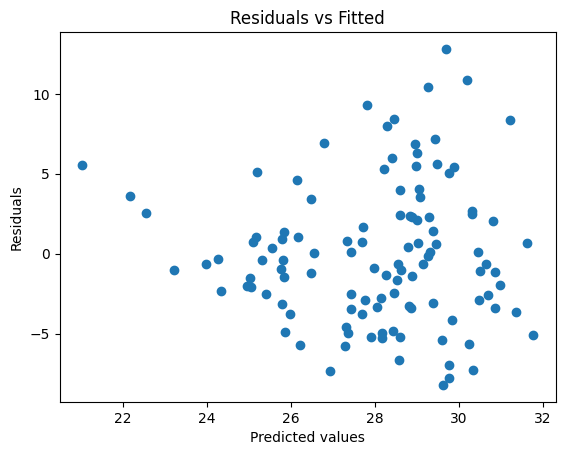

In [385]:
# Heteroskedasticity test

# Plot the residual error terms against the y_pred
y_pred = est.predict(est2)

residuals = y - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

In [386]:
# use the goldfeld-quandt test to check for heteroskedasticity
from statsmodels.stats.diagnostic import het_goldfeldquandt
name = ['F statistic', 'p-value']

test = het_goldfeldquandt(y, est2)
print(dict(zip(name, test)))


{'F statistic': np.float64(0.8104564763055512), 'p-value': np.float64(0.7729363170442245)}


In [387]:
# use the generalised white test to check for heteroskedasticity
from statsmodels.stats.diagnostic import het_white
# name = ['F statistic', 'p-value']
name = ["Lm value", "Lm p-value", "F value", "p-value"]

test = het_white(est.resid, est2)
print(dict(zip(name, test)))


{'Lm value': np.float64(16.883786530784093), 'Lm p-value': np.float64(0.2624238378463546), 'F value': np.float64(1.2296209083740215), 'p-value': np.float64(0.2667322591284973)}


In [388]:
# Variance Inflation Factor

# Calculate the VIF for each estimated coefficient using statsmodels package
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,VIF Factor
0,2.258271
1,16.691167
2,18.642489
3,1.481158


In [389]:
frames = {
    "gdp": gdp,
    # "lit": lit,
    # "lif": lif,
    # "urb": urb, 
    # "pop": pop
}
X, y = clean_up(incomet, frames)
print(X.shape, y.shape)

est2 = sm.add_constant(X)
est = sm.OLS(y, est2).fit()
print(est.summary())

(114,)
(114, 1) (114,)
                            OLS Regression Results                            
Dep. Variable:                   2018   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     17.99
Date:                Wed, 06 Nov 2024   Prob (F-statistic):           4.60e-05
Time:                        16:56:05   Log-Likelihood:                -333.32
No. Observations:                 114   AIC:                             670.6
Df Residuals:                     112   BIC:                             676.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.3938      0.

In [390]:
# Transform gdp to log gdp
# X["gdp"] = np.log(X["gdp"]) 

X["log_gdp"] = np.log(X["gdp"])
X["gdp_2"] = X["gdp"] ** 2
# X["gdp_3"] = X["gdp"] ** 3

# gdp = 0.19
# gdp + log_gdp = 0.226
# gdp + gdp_2 = 0.230
# gdp + log_gdp + gdp_2 = 0.241
# gdp + gdp_2 + gdp_3 = 0.094   

print(X.columns)
est2 = sm.add_constant(X)
est = sm.OLS(y, est2).fit()
print(est.summary())
    

Index(['gdp', 'log_gdp', 'gdp_2'], dtype='object')
                            OLS Regression Results                            
Dep. Variable:                   2018   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     8.216
Date:                Wed, 06 Nov 2024   Prob (F-statistic):           5.54e-05
Time:                        16:56:05   Log-Likelihood:                -330.28
No. Observations:                 114   AIC:                             668.6
Df Residuals:                     110   BIC:                             679.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c

# Income bottom 10%

In [391]:
frames = {
    "gdp": gdp,
    # "lit": lit,
    "lif": lif,
    "urb": urb,
    "pop": pop
}
X, y = clean_up(incomeb, frames)
print(X.shape, y.shape)

est2 = sm.add_constant(X)
est = sm.OLS(y, est2).fit()
print(est.summary())

(114,)
(113, 4) (113,)
                            OLS Regression Results                            
Dep. Variable:                   2018   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     4.271
Date:                Wed, 06 Nov 2024   Prob (F-statistic):            0.00302
Time:                        16:56:05   Log-Likelihood:                -124.76
No. Observations:                 113   AIC:                             259.5
Df Residuals:                     108   BIC:                             273.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0869      0.

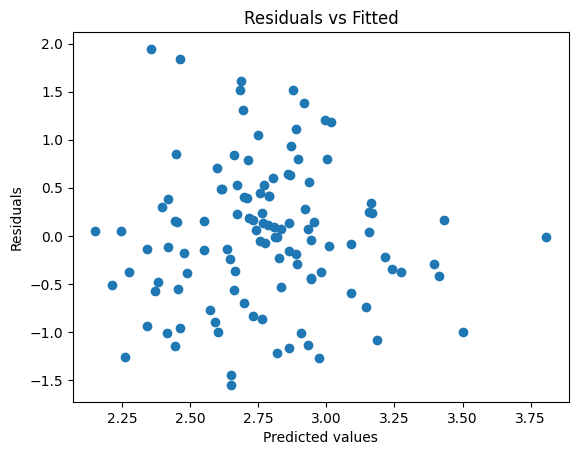

In [392]:
# Heteroscedasticity Test

# Plot the residual error terms against the y_pred
y_pred = est.predict(est2)

residuals = y - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()


In [393]:
# use the goldfeld-quandt test to check for heteroskedasticity
from statsmodels.stats.diagnostic import het_goldfeldquandt

test_result = het_goldfeldquandt(y, est2)
labels = ['F statistic', 'p-value']
print(dict(zip(labels, test_result)))


{'F statistic': np.float64(0.7616154231716267), 'p-value': np.float64(0.8338554274846148)}


In [394]:
# use the generalised white test to check for heteroskedasticity
from statsmodels.stats.diagnostic import het_white
# name = ['F statistic', 'p-value']
name = ["Lm value", "Lm p-value", "F value", "p-value"]

test = het_white(est.resid, est2)
print(dict(zip(name, test)))


{'Lm value': np.float64(10.02280660916113), 'Lm p-value': np.float64(0.760514145573167), 'F value': np.float64(0.6813124727321375), 'p-value': np.float64(0.7874334869827329)}


In [395]:
# Variance Inflation Factor

# Calculate the VIF for each estimated coefficient using statsmodels package
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,VIF Factor
0,2.258271
1,16.691167
2,18.642489
3,1.481158


In [396]:
frames = {
    "gdp": gdp,
    # "lit": lit,
    # "lif": lif,
    # "urb": urb,
    "pop": pop
}
X, y = clean_up(incomeb, frames)
print(X.shape, y.shape)

est2 = sm.add_constant(X)
est = sm.OLS(y, est2).fit()
print(est.summary())

(114,)
(113, 2) (113,)
                            OLS Regression Results                            
Dep. Variable:                   2018   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     2.514
Date:                Wed, 06 Nov 2024   Prob (F-statistic):             0.0856
Time:                        16:56:05   Log-Likelihood:                -130.53
No. Observations:                 113   AIC:                             267.1
Df Residuals:                     110   BIC:                             275.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6199      0.

Drastic decrease in explanation if urb is removed.

In [397]:
# Transform gdp to log gdp
# X["gdp"] = np.log(X["gdp"]) 

X["log_gdp"] = np.log(X["gdp"])
X["gdp_2"] = X["gdp"] ** 2
# X["gdp_3"] = X["gdp"] ** 3

# gdp = 0.137
# gdp + log gdp = 0.139
# gdp + gdp_2 = 0.147
# gdp + log gdp + gdp_2 = 0.160
# gdp + gdp_2 + gdp_3 = 0.037


print(X.columns)
est2 = sm.add_constant(X)
est = sm.OLS(y, est2).fit()
print(est.summary())
    

Index(['gdp', 'pop', 'log_gdp', 'gdp_2'], dtype='object')
                            OLS Regression Results                            
Dep. Variable:                   2018   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     3.130
Date:                Wed, 06 Nov 2024   Prob (F-statistic):             0.0177
Time:                        16:56:05   Log-Likelihood:                -126.86
No. Observations:                 113   AIC:                             263.7
Df Residuals:                     108   BIC:                             277.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

# Discussion